# Trees for indexing

In this lab you will explore how trees may be utilized for indexing of vector data.

In [ ]:
from sklearn.neighbors import BallTree, KDTree
import matplotlib.pyplot as plt

In [ ]:
import random
import numpy as np

def generate(N, dim, steps=10):
    res = np.zeros((N, dim))
    bins = steps ** dim
    for i in range(N):
        cell = random.randrange(bins)
        for d in range(dim):
            idx = (cell // steps ** d) % steps
            res[i, d] = idx / steps + random.random() / steps
    return res

## Get a dataset

This code will generate and plot a dataset of 30K 2D points, uniformely distributed in 1x1 square.

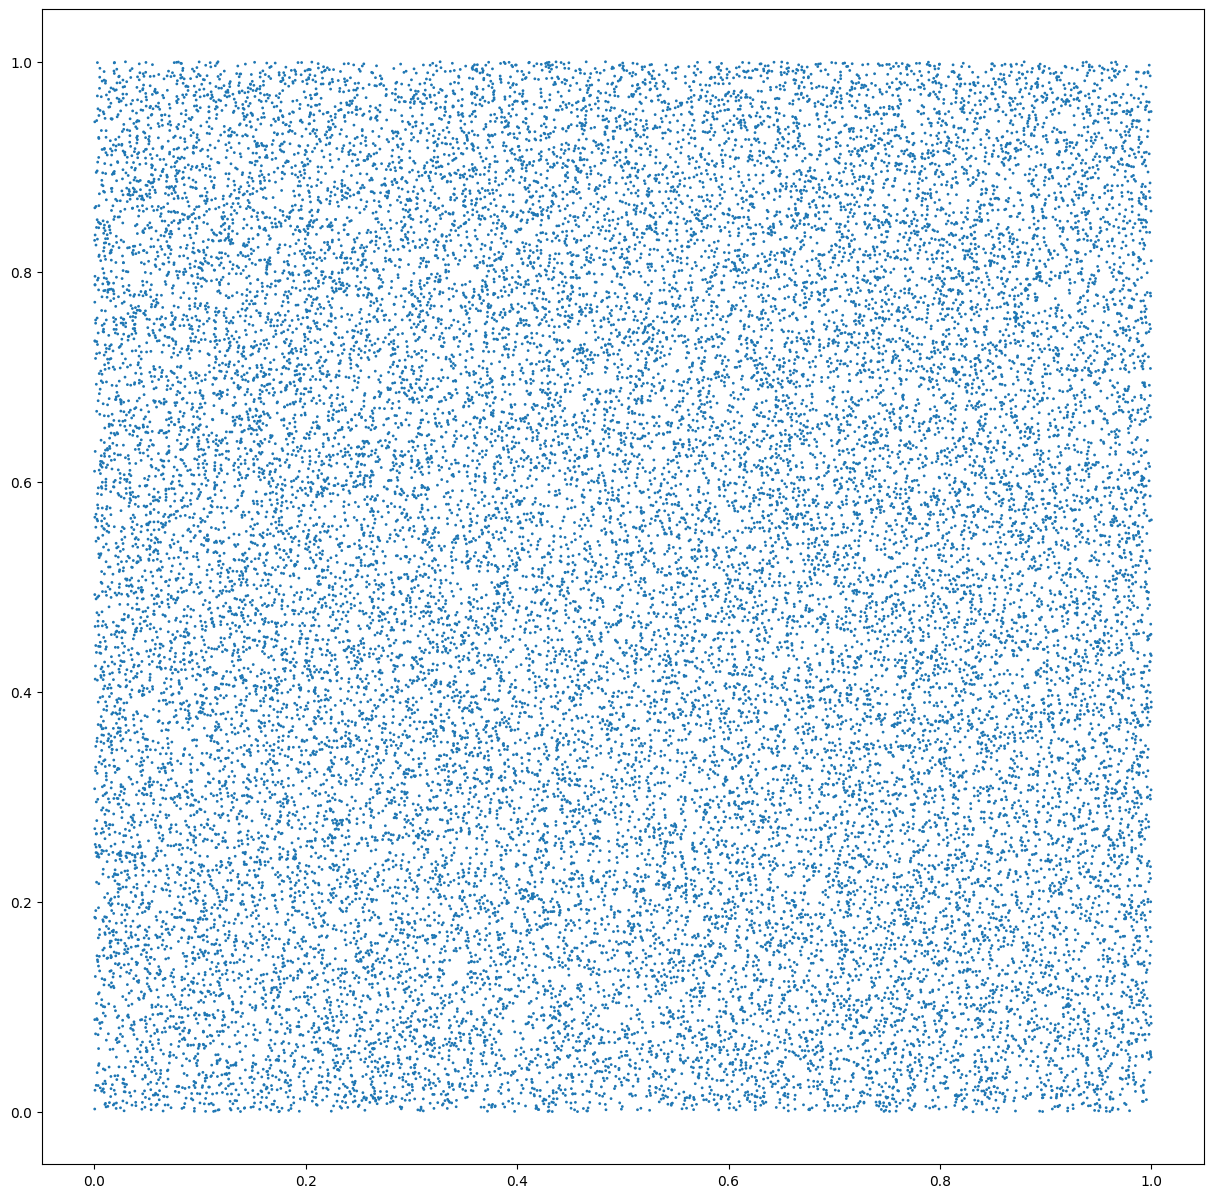

In [ ]:
data2d = generate(30000, 2)
plt.figure(figsize=(15, 15))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0])

# Build 4 tree indices: KDTree, BallTree, [VPTree](https://pypi.org/project/vptree/), and Annoy

Simple case. We use 2D points and Euclidean distance as a similarity metric.

In [ ]:
!pip install annoy vptree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.2-cp310-cp310-linux_x86_64.whl size=582691 sha256=021763c52ab91f746d49df3411d8ffd2ba219e347b5f7eba7e0a1a84303ecf92
  Stored in directory: /root/.cache/pip/wheels/7a/d9/59/473fa56df8e39430eeda369500b4e7127f5b243ba24c3c4297
  Created wheel for vptree: filename=vptree-1.3-py3-none-any.whl size=4564 sha256=e25eff8d5d3df669530a8072a6ee0a3b29c16f82575ba1dd4aaa9e271fe5a553
  Stored in directory: /root/.cache/pip/wheels/3a/eb/ca/904b67530bad0ab02a61978e03549e80bfb1ae07363edb3aab
Successfully built annoy vptree


In [ ]:
from annoy import AnnoyIndex
from vptree import VPTree
import time
import numpy as np

This is a query bucket for perpformance testing:

In [ ]:
bucket2d = generate(200, 2)

### Prepare ground truth

For this bucket we find exact nearest neighbour indices in `GT` list of lists.

In [ ]:
from scipy.spatial.distance import euclidean
from tqdm import tqdm


def get_GT(data, bucket):
    gt = []
    for i, row_b in enumerate(tqdm(bucket)):
        d = []
        for j, row_d in enumerate(data):
            d.append(euclidean(row_b, row_d))
        gt.append(np.argsort(d)[:1000])
    return gt

GT = get_GT(data2d, bucket2d)

100%|██████████| 200/200 [00:53<00:00,  3.76it/s]


## Formula for Recall@N

In [ ]:
def recall(i1, i2, N=1000):
    return len(set(i1).intersection(i2)) / N

## Assessing KD Tree

### Build

In [ ]:
# from scipy.spatial import KDTree
from sklearn.neighbors import KDTree
start = time.time()
kdtree = KDTree(data2d) # TODO write a code to build a KDTree out of data2d array
print(f"KDTree is ready in {time.time() - start :.5f} s")

KDTree is ready in 0.04271 s


### Sample query

(3000, 2)


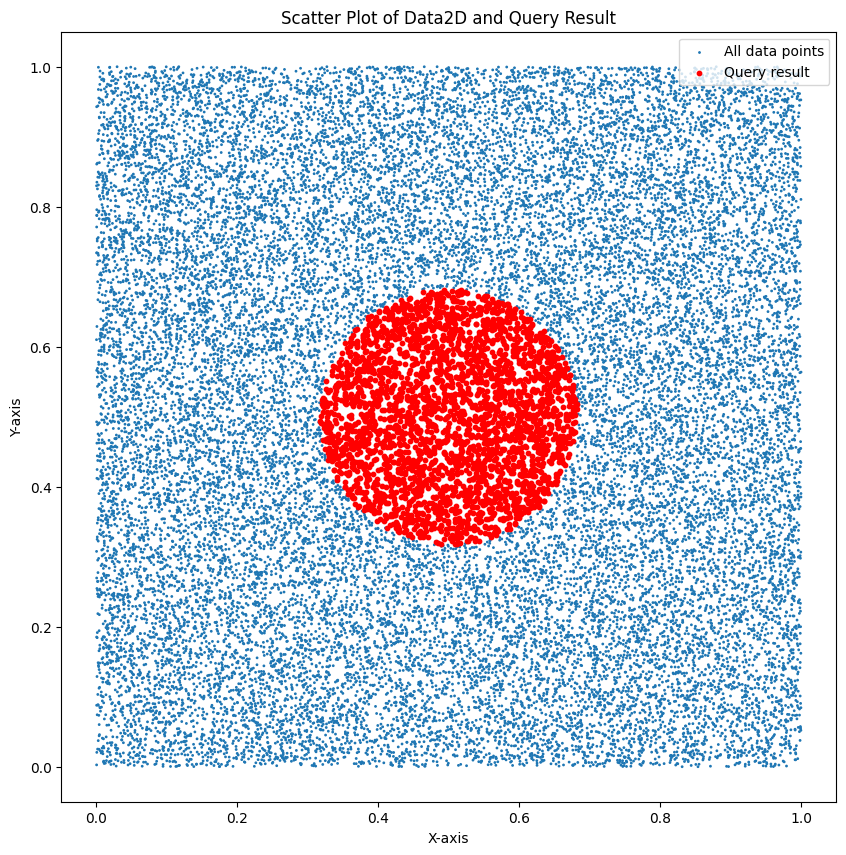

In [ ]:
# TODO scatter the points array (search result) on the background of data 
idx = kdtree.query([(.5, .5)], 3000, return_distance=False)[0]
points = data2d[idx, :]
print(points.shape)

plt.figure(figsize=(10, 10))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0], label='All data points')

# Scatter the points array (search result) on the background of data
plt.scatter(points[:, 0], points[:, 1], s=10, c='r', marker='o', label='Query result')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Data2D and Query Result')
plt.legend(loc='upper right')
plt.show()


### Bucket time and recall

In [ ]:
start = time.time()
r = kdtree.query(bucket2d, 1000, return_distance=False)
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.06392 s
Recall@1000 = 1.0000


## Assessing Ball Tree

### Build

In [ ]:
from sklearn.neighbors import BallTree
start = time.time()
balltree =  BallTree(data2d) # TODO write a code to build a BallTree out of data2d array
print(f"BallTree is ready in {time.time() - start :.5f} s")

BallTree is ready in 0.02703 s


### Sample query

(3000, 2)


<Figure size 1000x1000 with 0 Axes>

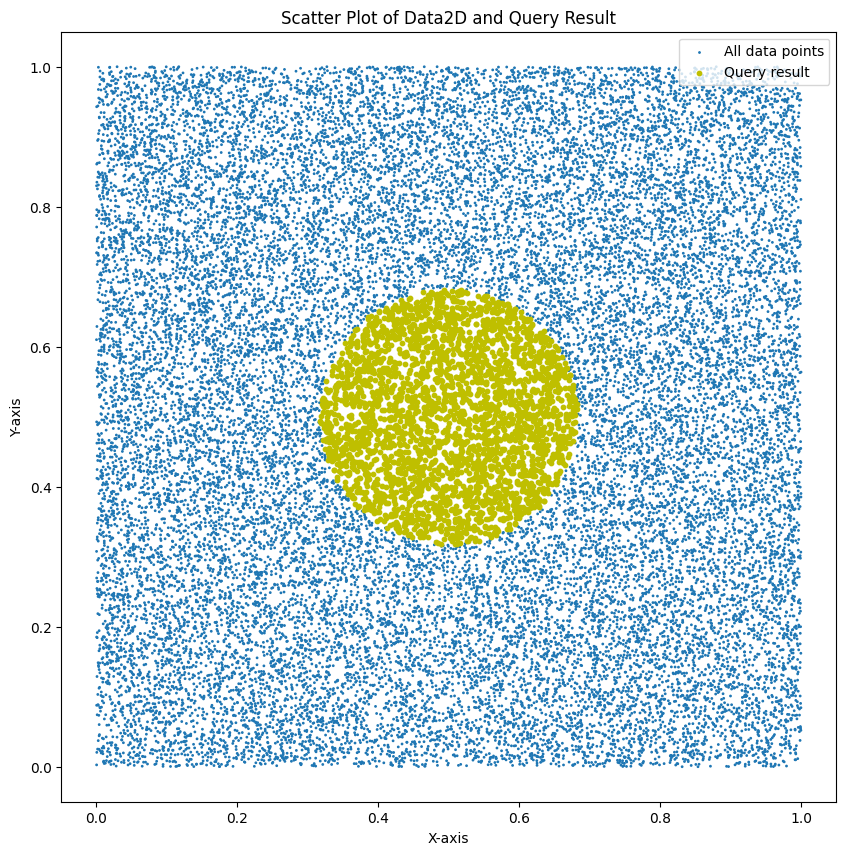

In [ ]:
idx = balltree.query([(.5, .5)], 3000, return_distance=False)[0]
points = data2d[idx, :]
print(points.shape)
plt.figure(figsize=(10, 10))

# plot like this

plt.figure(figsize=(10, 10))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0], label='All data points')

# Scatter the points array (search result) on the background of data
plt.scatter(points[:, 0], points[:, 1], s=10, c='y', marker='o', label='Query result')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Data2D and Query Result')
plt.legend(loc='upper right')
plt.show()


### Bucket time and recall

In [ ]:
start = time.time()
r = balltree.query(bucket2d, 1000, return_distance=False)
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.05624 s
Recall@1000 = 1.0000


## Assessing Annoy

### A single tree

In [ ]:
start = time.time()
# annoy1 = # Build and populate a SINGLE Annoy tree. Use Euclidean distance
annoy1 = AnnoyIndex(2, 'euclidean')
for i, v in enumerate(data2d):
    annoy1.add_item(i, v)
annoy1.build(1)

print(f"Annoy is ready in {time.time() - start:.5} s")

Annoy is ready in 0.16386 s


### Sample query with 1 tree

(3000, 2)


<Figure size 1000x1000 with 0 Axes>

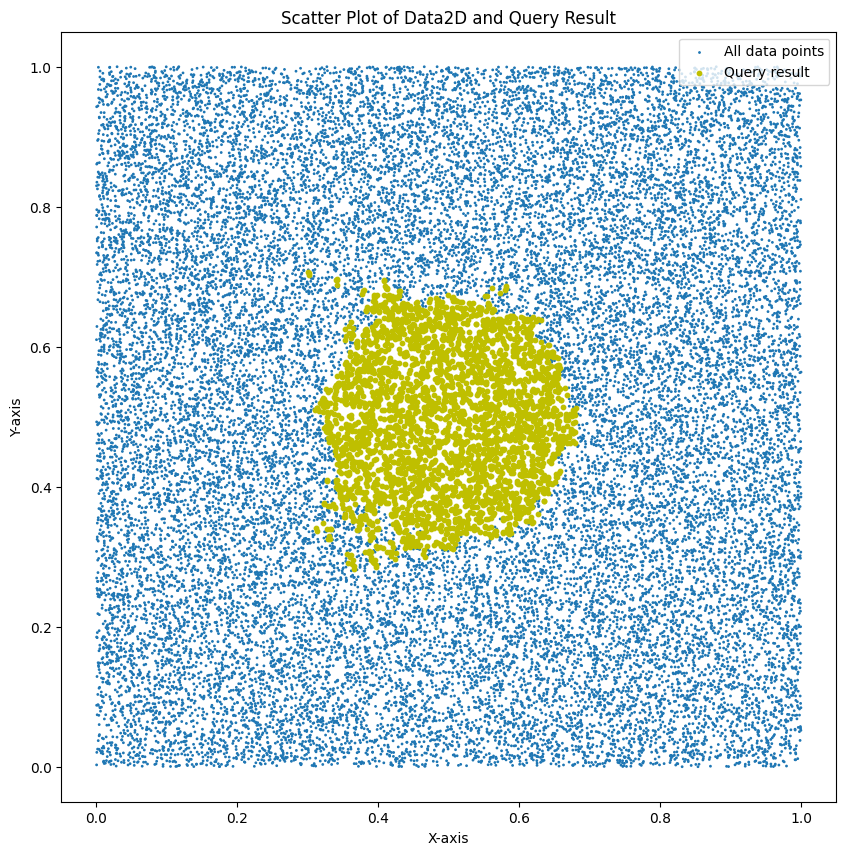

In [ ]:
idx = annoy1.get_nns_by_vector([.5, .5], 3000)
points = data2d[idx, :]
print(points.shape)
plt.figure(figsize=(10, 10))

# plot
plt.figure(figsize=(10, 10))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0], label='All data points')

# Scatter the points array (search result) on the background of data
plt.scatter(points[:, 0], points[:, 1], s=10, c='y', marker='o', label='Query result')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Data2D and Query Result')
plt.legend(loc='upper right')
plt.show()



### Time and recall with 1 annoy tree

In [ ]:
start = time.time()
r = [annoy1.get_nns_by_vector(q, 1000) for q in bucket2d]
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.05943 s
Recall@1000 = 0.9184


### Assessing Annoy multiple trees

Annoy is ready in 0.31812 s
(3000, 2)


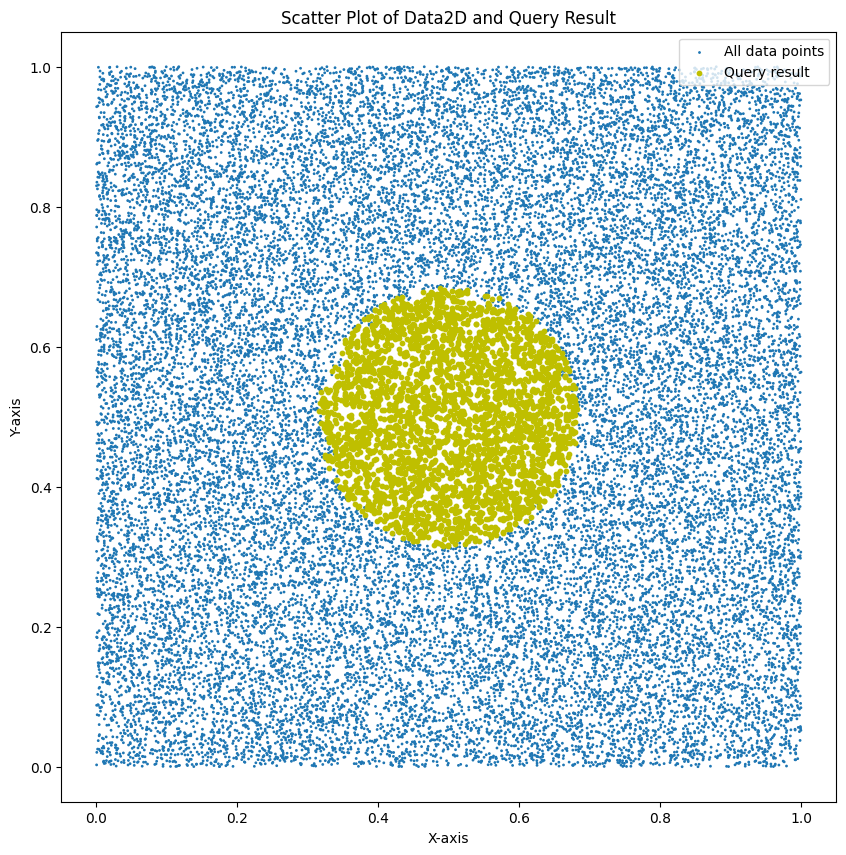

In [ ]:
start = time.time()
# annoy3 = # build and populate Annoy with 3 trees. Use Euclidean distance
annoy3 = AnnoyIndex(2, 'euclidean')
for i, v in enumerate(data2d):
    annoy3.add_item(i, v)
annoy3.build(3)

print(f"Annoy is ready in {time.time() - start:.5} s")

idx = annoy3.get_nns_by_vector([.5, .5], 3000)
points = data2d[idx, :]
print(points.shape)
# plt.figure(figsize=(10, 10))

# plot

plt.figure(figsize=(10, 10))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0], label='All data points')

# Scatter the points array (search result) on the background of data
plt.scatter(points[:, 0], points[:, 1], s=10, c='y', marker='o', label='Query result')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Data2D and Query Result')
plt.legend(loc='upper right')
plt.show()


### Time and recall for multiple annoy trees

In [ ]:
start = time.time()
r = [annoy3.get_nns_by_vector(q, 1000) for q in bucket2d]
print(f"Queries done in {time.time() - start :.5f} s")
rec = sum([recall(GT[i], r[i]) for i in range(len(bucket2d))]) / len(bucket2d)
print(f"Recall@1000 = {rec:.4f}")

Queries done in 0.11663 s
Recall@1000 = 0.9797


### Assessing Vantage Point Tree

In [ ]:

from scipy.spatial.distance import euclidean
from vptree import VPTree
import time

def custom_distance(x, y):
    return euclidean(x[1], y[1])

start = time.time()
vptree = VPTree(list(enumerate(data2d)), custom_distance)
print(f"VPTree is ready in {time.time() - start :.5f} s")

idx = [x[1][0] for x in vptree.get_n_nearest_neighbors((None, [.5, .5]), 3000)]
points = data2d[idx, :]
print(points.shape)

VPTree is ready in 9.02103 s
(3000, 2)


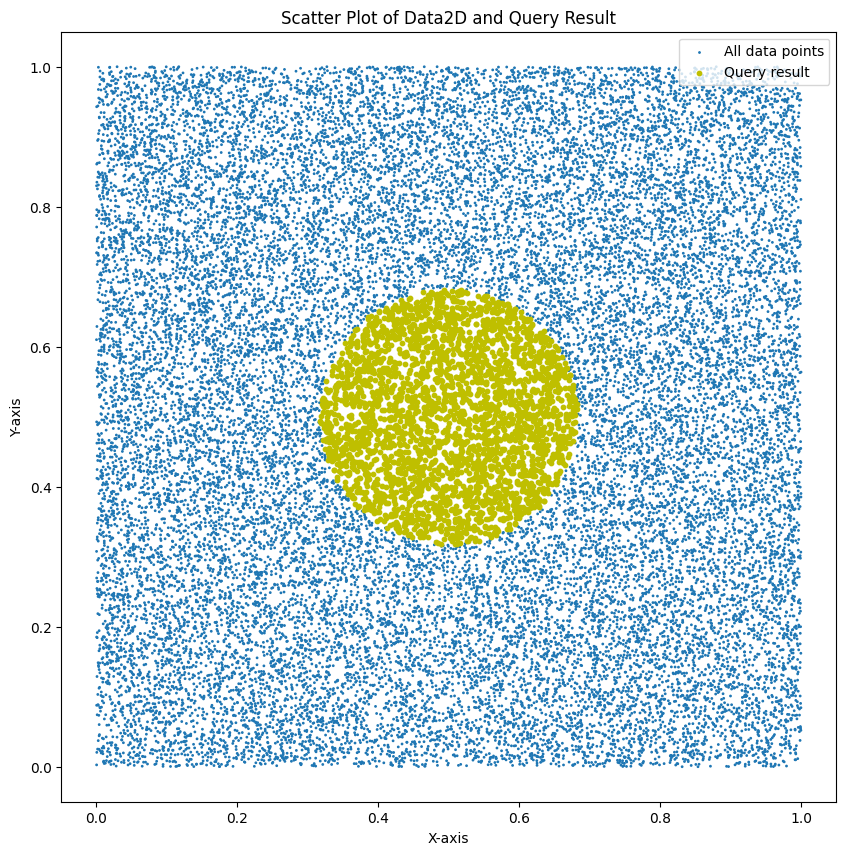

In [ ]:
# idx = [x[1][0] for x in vptree.get_n_nearest_neighbors([.5, .5], 3000)]
# points = data2d[idx, :]
# print(points.shape)
# plt.figure(figsize=(10, 10))

# plot

plt.figure(figsize=(10, 10))
plt.scatter(data2d[:, 0], data2d[:, 1], s=[1] * data2d.shape[0], label='All data points')

# Scatter the points array (search result) on the background of data
plt.scatter(points[:, 0], points[:, 1], s=10, c='y', marker='o', label='Query result')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of Data2D and Query Result')
plt.legend(loc='upper right')
plt.show()

# Trees scalability testing

We will vary `D` parameter which corresponds for the data dimensionality. We expect that with higher dimensions our trees should loose speed as well as recall.

`VPTree` left the contest due to unacceptable speed. We test KDTree, BallTree, Annoy with 20 trees, and Annoy with 100 trees.

In [ ]:
statistics = {"D":[], "tree":[], "construction":[], "search":[], "recall":[]}

for D in [2, 5, 10, 15, 50, 100, 200]:
    data = generate(50000, D)
    bucket = generate(50, D)
    
    myGT = get_GT(data, bucket)
    
    ###################################
    print(f"kdtree {D}")
    start = time.time()
    kdtree = KDTree(data)
    statistics["D"].append(D)
    statistics["tree"].append("kdtree")
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r = kdtree.query(bucket, 1000, return_distance=False)
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################
    
    ###################################
    print(f"balltree {D}")
    start = time.time()
    balltree = BallTree(data)
    statistics["D"].append(D)
    statistics["tree"].append("balltree")
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r = balltree.query(bucket, 1000, return_distance=False)
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################
    
    ###################################
    print(f"annoy-20 {D}")
    statistics["D"].append(D)
    statistics["tree"].append("annoy20")

    start = time.time()
    annoy20 = AnnoyIndex(data.shape[1], 'euclidean')
    for i, v in enumerate(data):
        annoy20.add_item(i, v)
    annoy20.build(20, n_jobs=-1)
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r  = [annoy20.get_nns_by_vector(q, 1000) for q in bucket]
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################
    
    
    ###################################
    print(f"annoy-100 {D}")
    statistics["D"].append(D)
    statistics["tree"].append("annoy100")

    start = time.time()
    annoy100 = AnnoyIndex(data.shape[1], 'euclidean')
    for i, v in enumerate(data):
        annoy100.add_item(i, v)
    annoy100.build(100, n_jobs=-1)
    statistics["construction"].append(time.time() - start)
    start = time.time()
    r  = [annoy100.get_nns_by_vector(q, 1000) for q in bucket]
    statistics["search"].append(time.time() - start)
    rec = sum([recall(myGT[i], r[i]) for i in range(len(bucket))]) / len(bucket)
    statistics["recall"].append(rec)
    ###################################

100%|██████████| 50/50 [00:17<00:00,  2.79it/s]


kdtree 2
balltree 2
annoy-20 2
annoy-100 2


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


kdtree 5
balltree 5
annoy-20 5
annoy-100 5


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


kdtree 10
balltree 10
annoy-20 10
annoy-100 10


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


kdtree 15
balltree 15
annoy-20 15
annoy-100 15


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


kdtree 50
balltree 50
annoy-20 50
annoy-100 50


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]


kdtree 100
balltree 100
annoy-20 100
annoy-100 100


100%|██████████| 50/50 [00:21<00:00,  2.38it/s]


kdtree 200
balltree 200
annoy-20 200
annoy-100 200


In [ ]:
import pandas as pd
df = pd.DataFrame(statistics)
df

D      tree  construction    search   recall
0     2    kdtree      0.027425  0.012255  1.00000
1     2  balltree      0.021613  0.014565  1.00000
2     2   annoy20      1.934850  0.163486  0.99998
3     2  annoy100     10.873395  0.857499  1.00000
4     5    kdtree      0.048748  0.028158  1.00000
5     5  balltree      0.036887  0.033519  1.00000
6     5   annoy20      1.491580  0.166924  0.99984
7     5  annoy100      8.745095  0.777469  1.00000
8    10    kdtree      0.098352  0.216967  1.00000
9    10  balltree      0.114100  0.165891  1.00000
10   10   annoy20      2.084667  0.206133  0.99510
11   10  annoy100      5.123628  0.735417  1.00000
12   15    kdtree      0.225483  0.319384  1.00000
13   15  balltree      0.154559  0.282877  1.00000
14   15   annoy20      1.796325  0.159393  0.97544
15   15  annoy100      5.630131  0.696220  0.99996
16   50    kdtree      0.504565  0.636594  1.00000
17   50  balltree      0.412161  0.562574  1.00000
18   50   annoy20      0.985008  0.150185  0.78198
19   50  annoy100      3.687707  0.579612  0.99844
20  100    kdtree      0.999631  1.274228  1.00000
21  100  balltree      1.302164  1.233093  1.00000
22  100   annoy20      1.298047  0.170985  0.64872
23  100  annoy100      4.453428  0.574938  0.99150
24  200    kdtree      2.815063  2.359581  1.00000
25  200  balltree      2.353420  1.679725  1.00000
26  200   annoy20      2.131967  0.237332  0.54902
27  200  annoy100      7.468051  0.823526  0.97788

## Graphs analysis

Look at the graphs. Discuss, which data structure you will choose, and for which task?

- For Computer Graphics and Geospacial data?
- For text embedding?
- With volatile data?
- With stable data?
- In Web search?
- In library search?

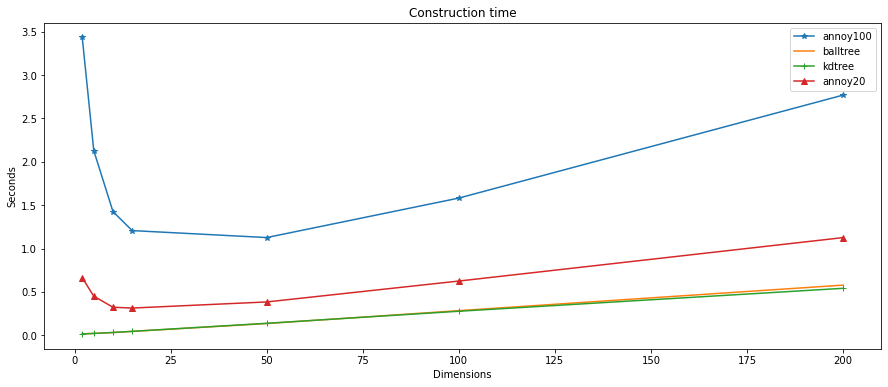

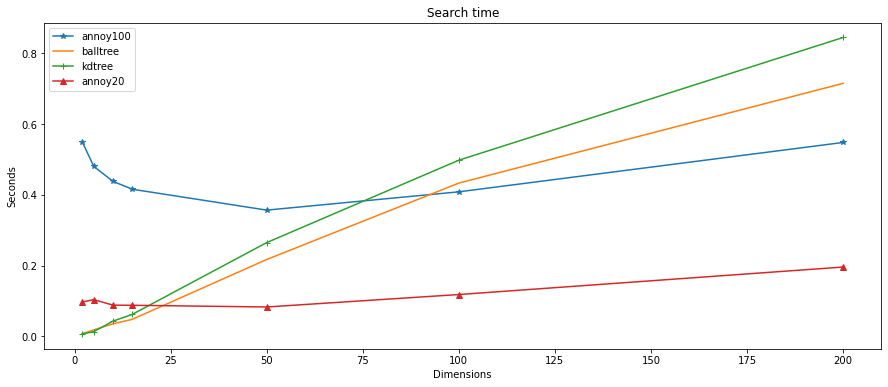

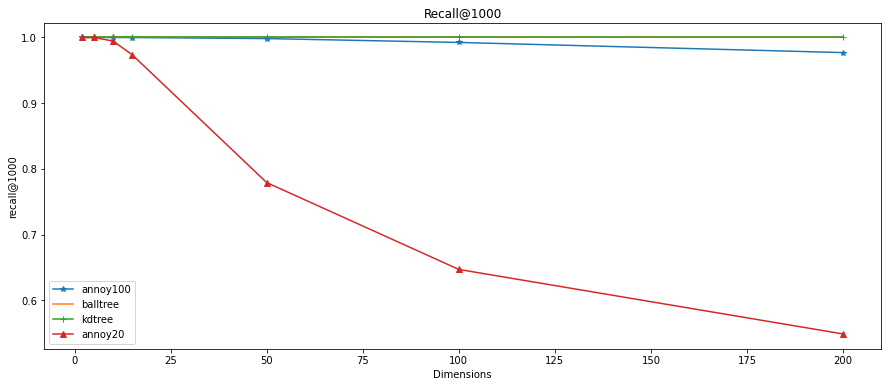

In [ ]:
types = set(df['tree'])
markers = dict(zip(types, ["*", "", "+", "^"]))

plt.figure(figsize=(15, 6))
plt.title("Construction time")
for typ in types:
    x = df[df['tree'] == typ]['D']
    y = df[df['tree'] == typ]['construction']
    plt.plot(x, y, label=typ, marker=markers[typ])
plt.xlabel("Dimensions")
plt.ylabel("Seconds")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.title("Search time")
for typ in types:
    x = df[df['tree'] == typ]['D']
    y = df[df['tree'] == typ]['search']
    plt.plot(x, y, label=typ, marker=markers[typ])
plt.ylabel("Seconds")
plt.xlabel("Dimensions")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.title("Recall@1000")
for typ in types:
    x = df[df['tree'] == typ]['D']
    y = df[df['tree'] == typ]['recall']
    plt.plot(x, y, label=typ, marker=markers[typ])
plt.xlabel("Dimensions")
plt.ylabel("recall@1000")
plt.legend()
plt.show()

# 3. Questions to discuss

1. Should we trust `pip`-based implementations? If no, how to validate?
2. What should be the strategy to choose index structure for your data? Take dimensions, size, implementations into account.
3. We measured 3 numbers, representing data structures. Can we consider anything else? Open http://ann-benchmarks.com/ and see, what they care about.
4. Is there anything missing in their benchmarks?

# 4. Advanced problem

What will change in the picture, if you change `euclidean` metric with `cosine`? Can you implement this?